## <center> **SIREN**: Sinusoidal Representation Networks
###### <center> _Sitzmann, V., Martel, J., Bergman, A., Lindell, D., and Wetzstein, G. 2020. [Implicit Neural Representations with Periodic Activation Functions](https://www.vincentsitzmann.com/siren/). In Proc. NeurIPS._

## <center> Audio Mapping Function
### $$ f(t): \mathbb{R} \to \mathbb{R} $$

### $$ \text{Cordinate Map}: \mathbb{R} \to \mathbb{R} : [t] \to [A] $$
### $$ \text{Feature Map}: \mathbb{R}^{\text{features}} \to \mathbb{R} : [t_{1 \cdots k}] \to [A] $$
### $$ \text{Final Map}: \mathbb{R} \to \mathbb{R}^{\text{features}} \to \mathbb{R} : [t] \to [t_{1 \cdots k}] \to [A] $$

### Run **only in Colab** to install Latex Fonts and Add `latexify.py` in the upload files

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

from latexify import latexify
latexify(columns = 2)

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

mps


### Get the Audio File

In [ ]:
!wget https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav

In [21]:
from IPython.display import Audio
Audio('gt_bach.wav')

In [22]:
import torchaudio
audio, sr = torchaudio.load('./gt_bach.wav')

$$ \text{Sampling Frequency} = \frac{\text{No. of Samples}}{\text{Time Taken}} $$

In [23]:
sr

44100

In [24]:
print(audio.shape)
audio = audio[0]

torch.Size([1, 308207])


In [25]:
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

Audio length: 6.988820861678004 seconds


In [26]:
audio

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0473, 0.0297, 0.0168])

In [27]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

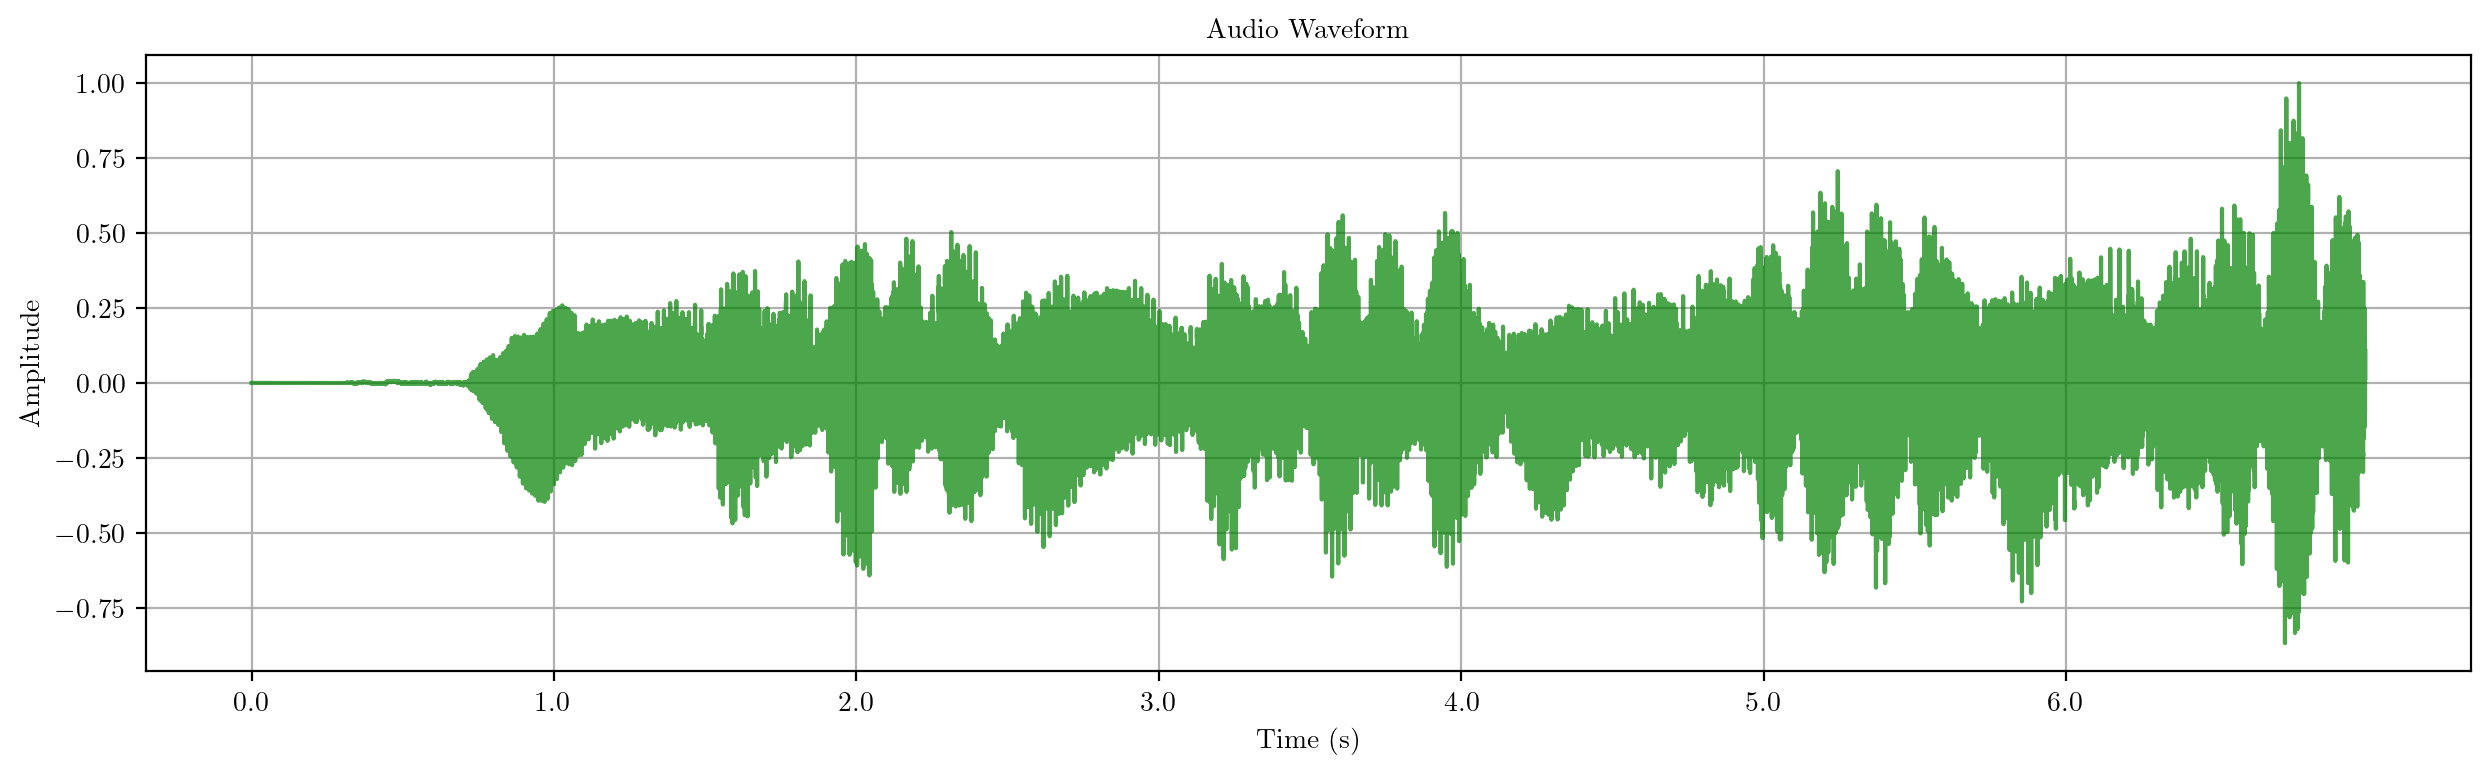

In [28]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

### Using the last 2 seconds of the Audio

In [29]:
audio = audio[-2 * sr:]
print(audio.shape)
print(audio)

torch.Size([88200])
tensor([-0.0099,  0.0410,  0.0865,  ...,  0.0473,  0.0297,  0.0168])


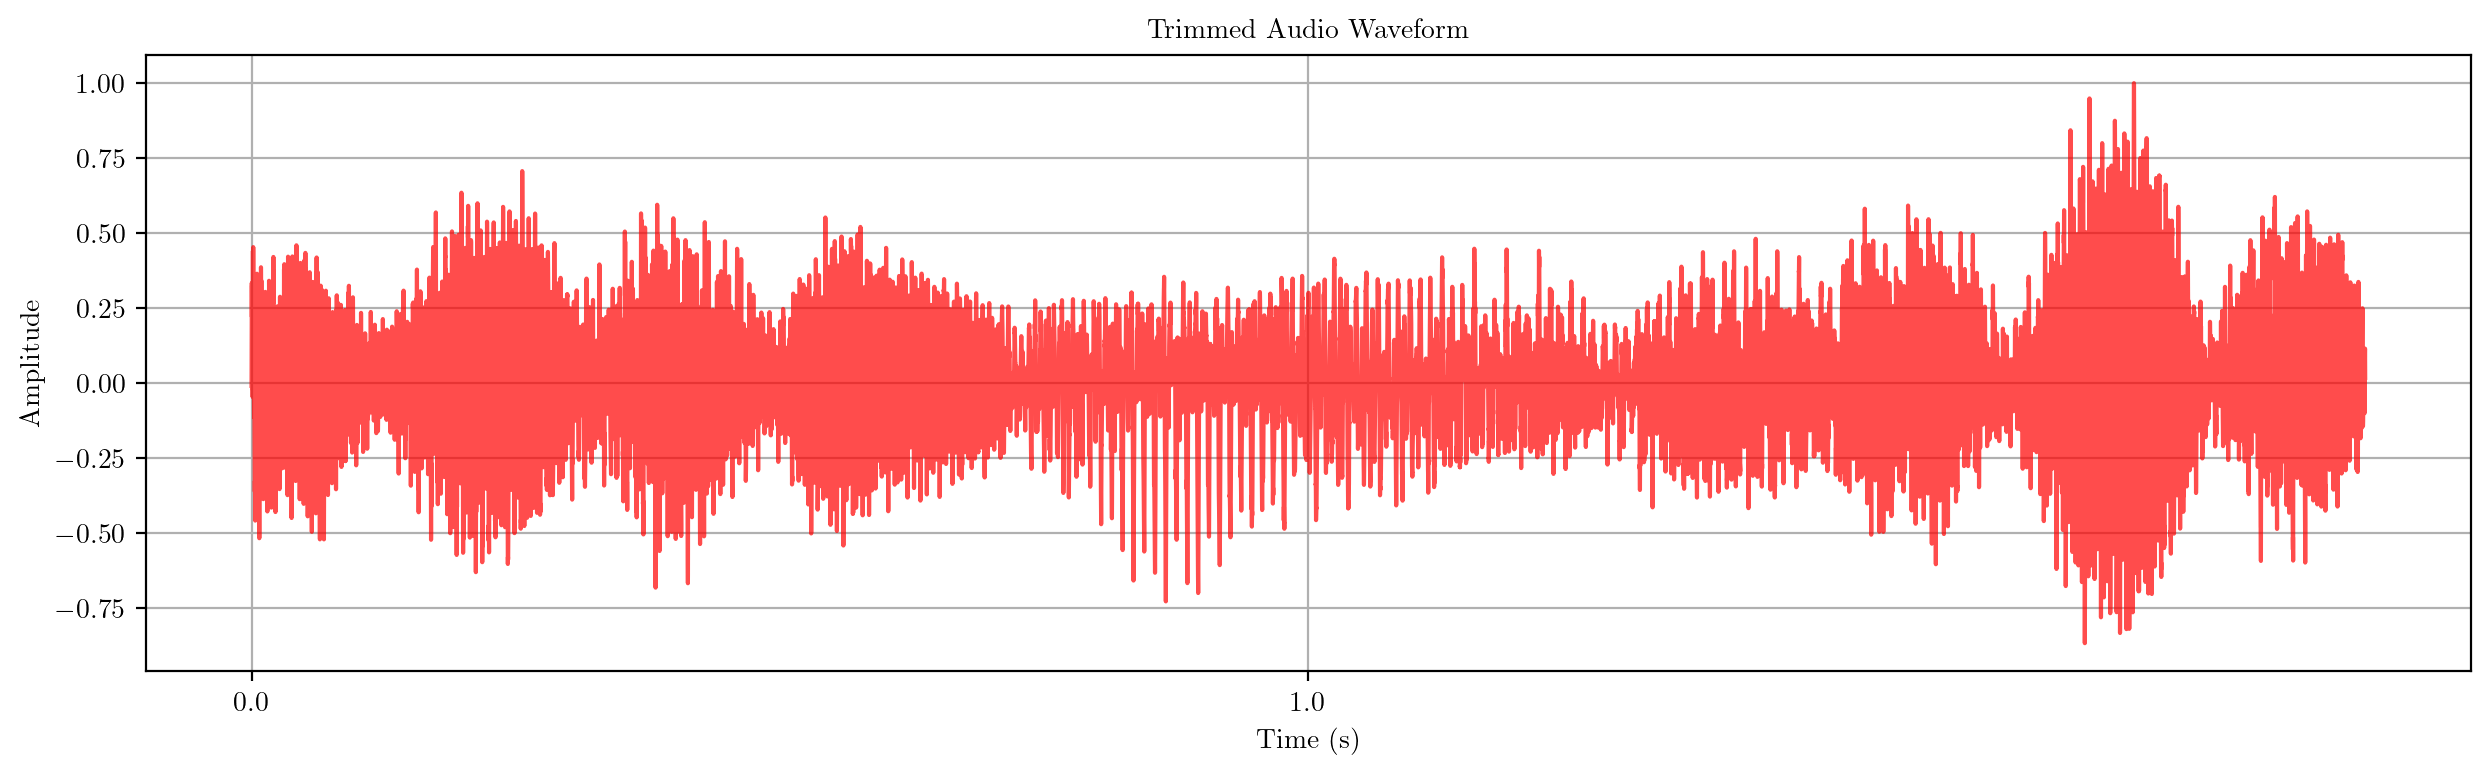

In [30]:
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

### Creating the Time Series $t = [-100.0, \cdots, 100.0]$ domain shifted to $[-100, 100]$

In [31]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([88200, 1])
tensor([[-100.0000],
        [ -99.9977],
        [ -99.9955],
        ...,
        [  99.9955],
        [  99.9977],
        [ 100.0000]])


In [32]:
Audio(audio, rate = sr)

### Gaussian Kernel and Random Fourier Features

#### The Gaussian Kernel
$$ K(\textbf{x}, \textbf{x}') = \exp{(-\gamma \lVert \textbf{x} - \textbf{x}' \rVert^2)}, \gamma = \frac{1}{2\sigma^2}$$

#### Since this is infinte dimensional, it can approximated with the **Fourier Transform** of this kernel
###### _(Rahimi, A., & Recht, B. (2007). [Random features for large-scale kernel machines](https://papers.nips.cc/paper_files/paper/2007/hash/013a006f03dbc5392effeb8f18fda755-Abstract.html). Advances in Neural Information Processing Systems, 1177–1184.)_

$$\gamma(\mathbf{v}) = [\cos({2 \pi \mathbf{B}\mathbf{v}}), \sin({2 \pi \mathbf{B}\mathbf{v}})]^T $$
$$ \mathbf{v} \in \mathbb{R}^{\text{input}} $$
Each entry in $\mathbf{B} \in \mathbb{R}^{m \times \text{input}}$ is sampled from $\mathcal{N}(0, \sigma^2 I)$
$$ \gamma(\mathbf{v}) = [a_1 \cos({2 \pi \mathbf{b}_1^T\mathbf{v}}), a_1 \sin({2 \pi \mathbf{b}_1^T\mathbf{v}}), \cdots, a_m \cos({2 \pi \mathbf{b}_m^T\mathbf{v}}), a_m \sin({2 \pi \mathbf{b}_m^T\mathbf{v}})]^T $$

In [33]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [34]:
num_features = 5000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([88200, 5000])
tensor([[ 0.0088, -0.0179, -0.0190,  ..., -0.0196,  0.0071, -0.0053],
        [ 0.0050, -0.0194, -0.0189,  ..., -0.0198,  0.0093, -0.0090],
        [ 0.0011, -0.0200, -0.0189,  ..., -0.0199,  0.0113, -0.0124],
        ...,
        [-0.0141, -0.0200, -0.0148,  ...,  0.0045, -0.0043, -0.0085],
        [-0.0110, -0.0196, -0.0146,  ...,  0.0057, -0.0019, -0.0119],
        [-0.0074, -0.0183, -0.0144,  ...,  0.0068,  0.0005, -0.0148]])


## Fit a Linear Model over this expanded feature domain
### $\textbf{X}_{(88200, 5000)}, \textbf{y}_{(88200, )}$

In [35]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(88200,)


### On saving the model weights and sound file

In [ ]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [36]:
print(pred_audio)
print(audio)

[-0.08589885 -0.05097864 -0.01513526 ... -0.09006581 -0.10923598
 -0.1291264 ]
tensor([-0.0099,  0.0410,  0.0865,  ...,  0.0473,  0.0297,  0.0168])


### Reconstruction Losses ($L_1$ and $L_2$)
$$ L_1 = \lVert \text{Reconstructed} - \text{Original} \rVert_1 $$
$$ L_2 = \lVert \text{Reconstructed} - \text{Original} \rVert_2 $$

In [37]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(40.0905, 9472.825)

## Reconstructed Audio

In [38]:
Audio(pred_audio, rate = sr)

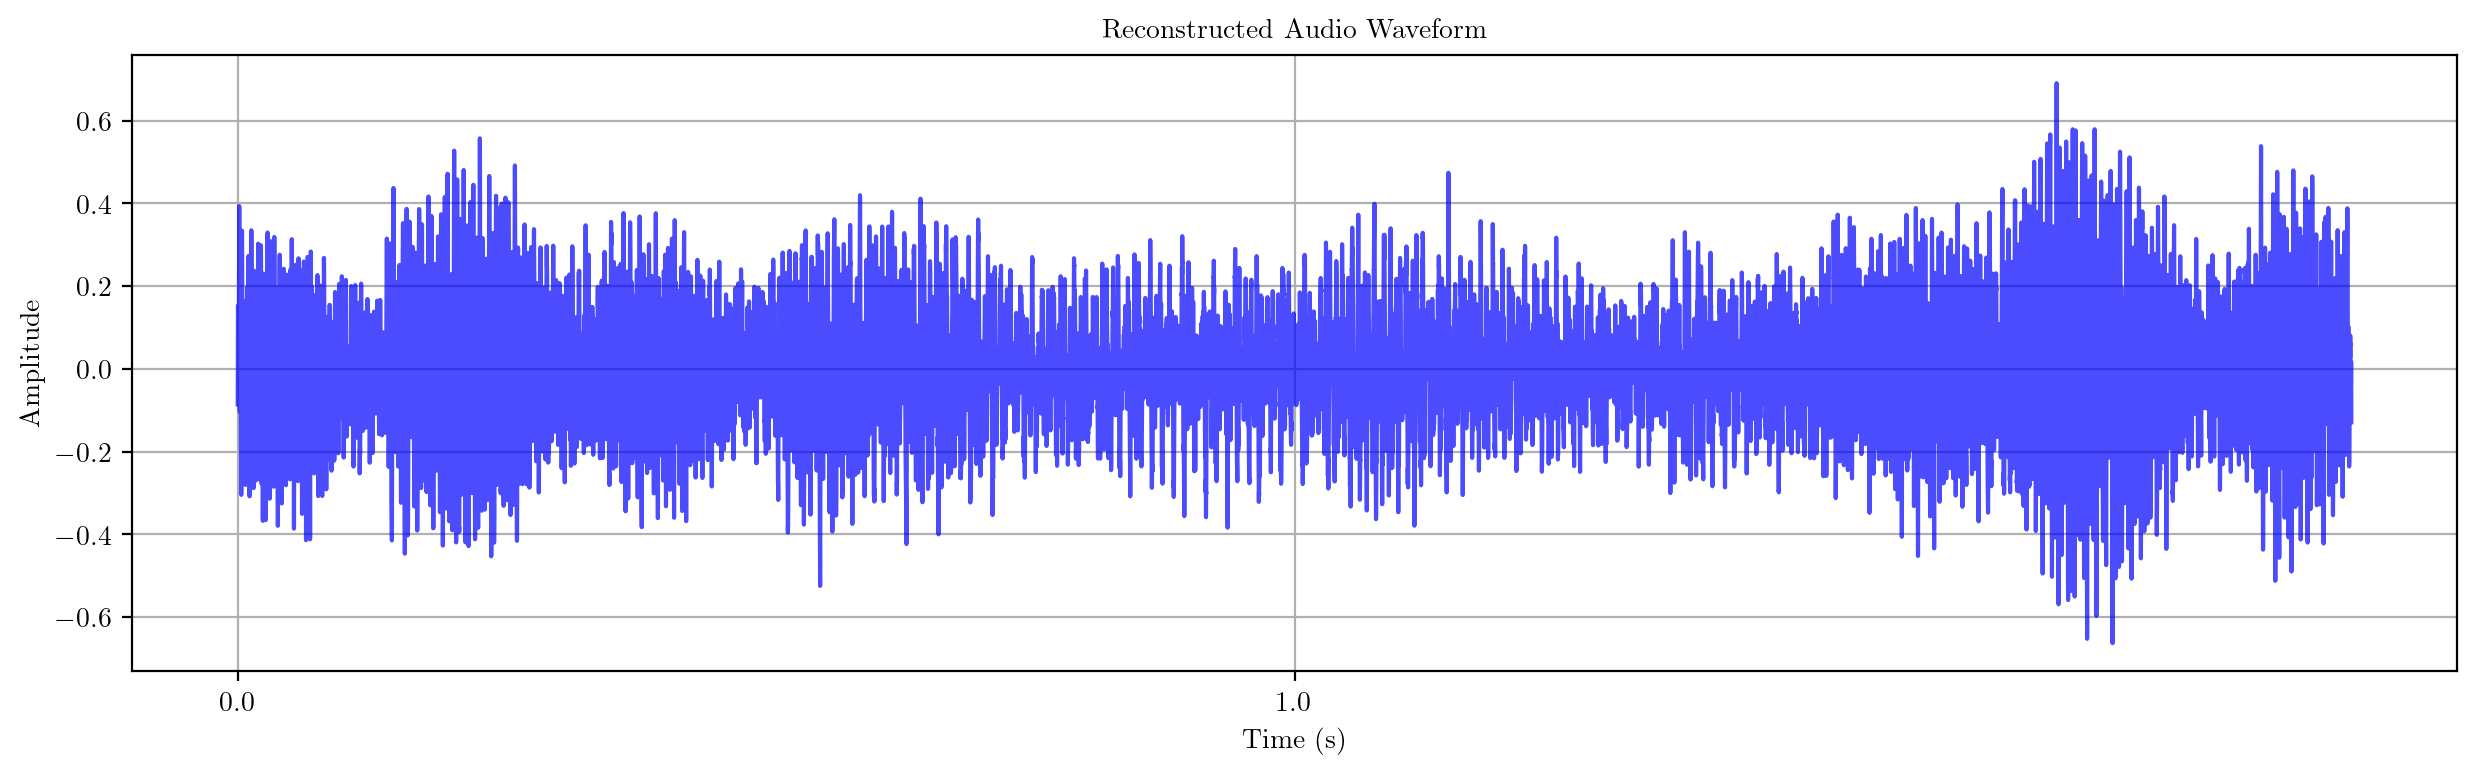

In [39]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

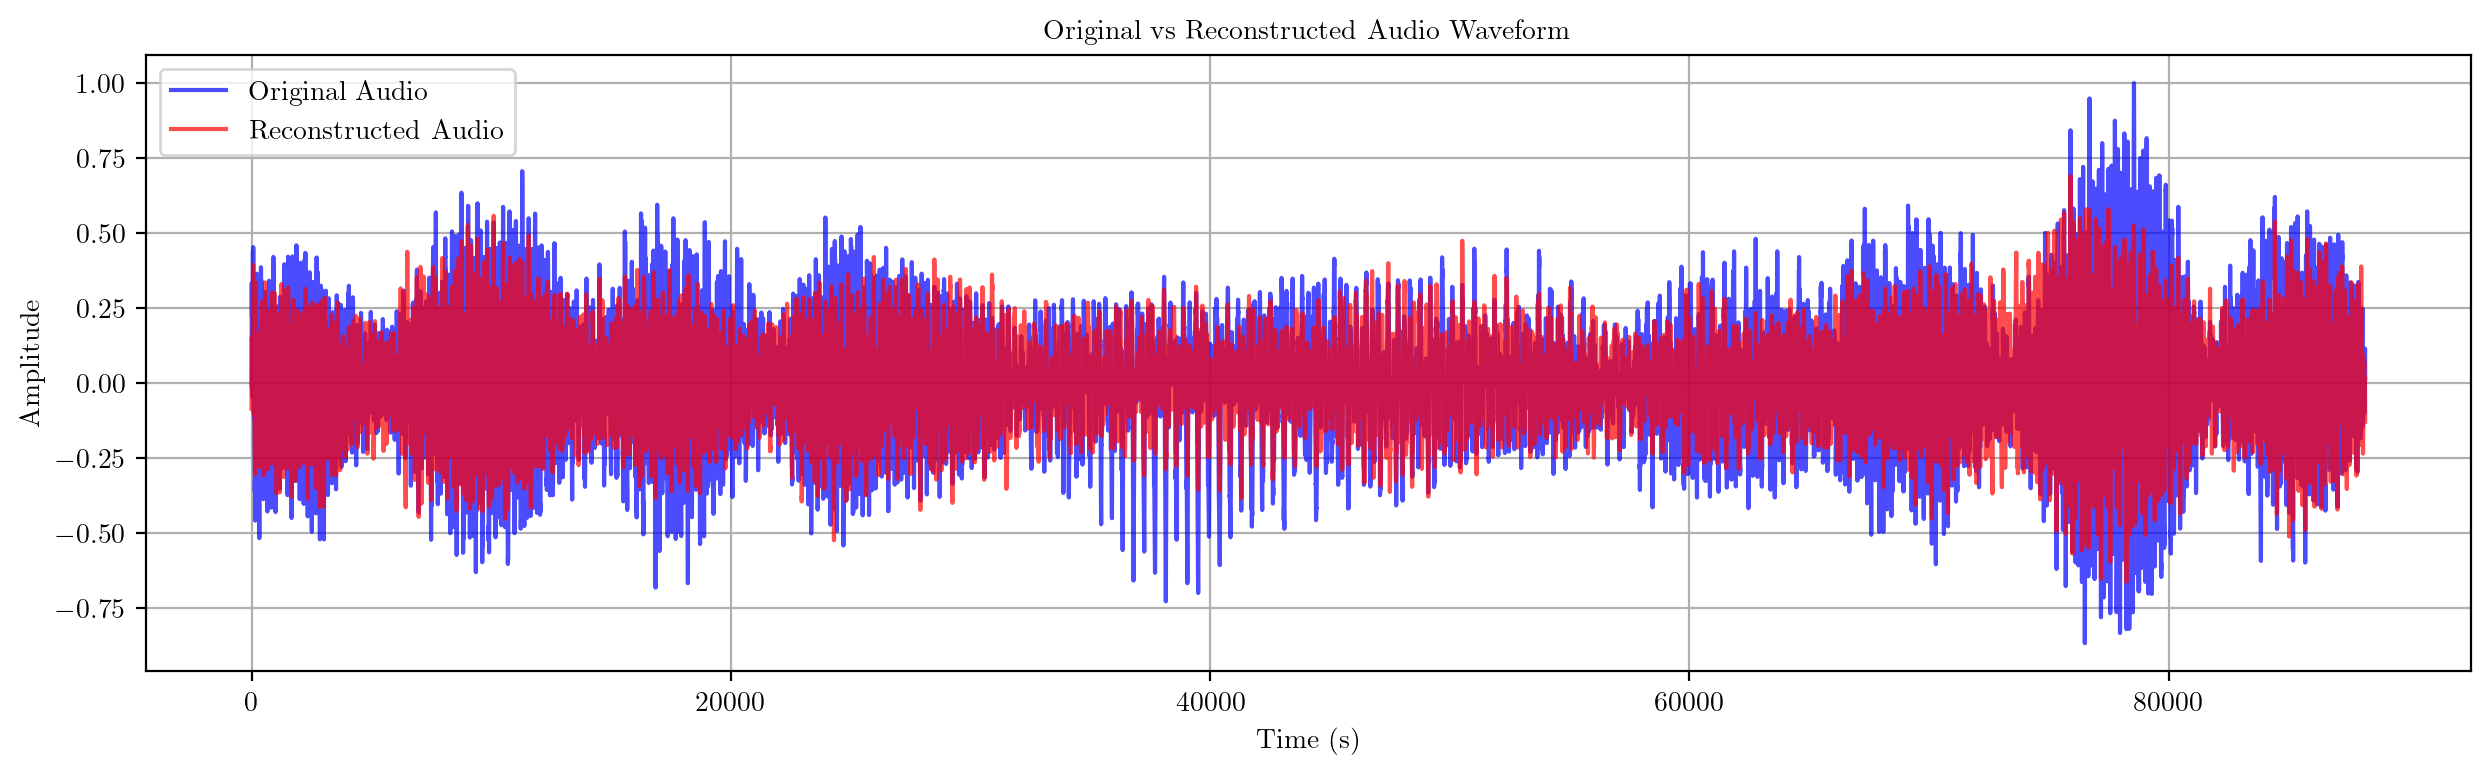

In [40]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

### If trained on Raw Time Series Domain $\to$ **Line** as the prediction

In [41]:
model = LinearRegression()
model.fit(X, audio)

pred_audio1 = model.predict(X)
print(pred_audio1.shape)

(88200,)


In [42]:
print(pred_audio1)
print(audio)

[ 2.9926328e-04  2.9925935e-04  2.9925545e-04 ... -4.5769411e-05
 -4.5773326e-05 -4.5777226e-05]
tensor([-0.0099,  0.0410,  0.0865,  ...,  0.0473,  0.0297,  0.0168])


In [43]:
np.linalg.norm(pred_audio1 - audio.numpy()), np.linalg.norm((pred_audio1 - audio.numpy()), ord = 1)

(61.988785, 14268.9795)

In [44]:
Audio(pred_audio1, rate = sr)

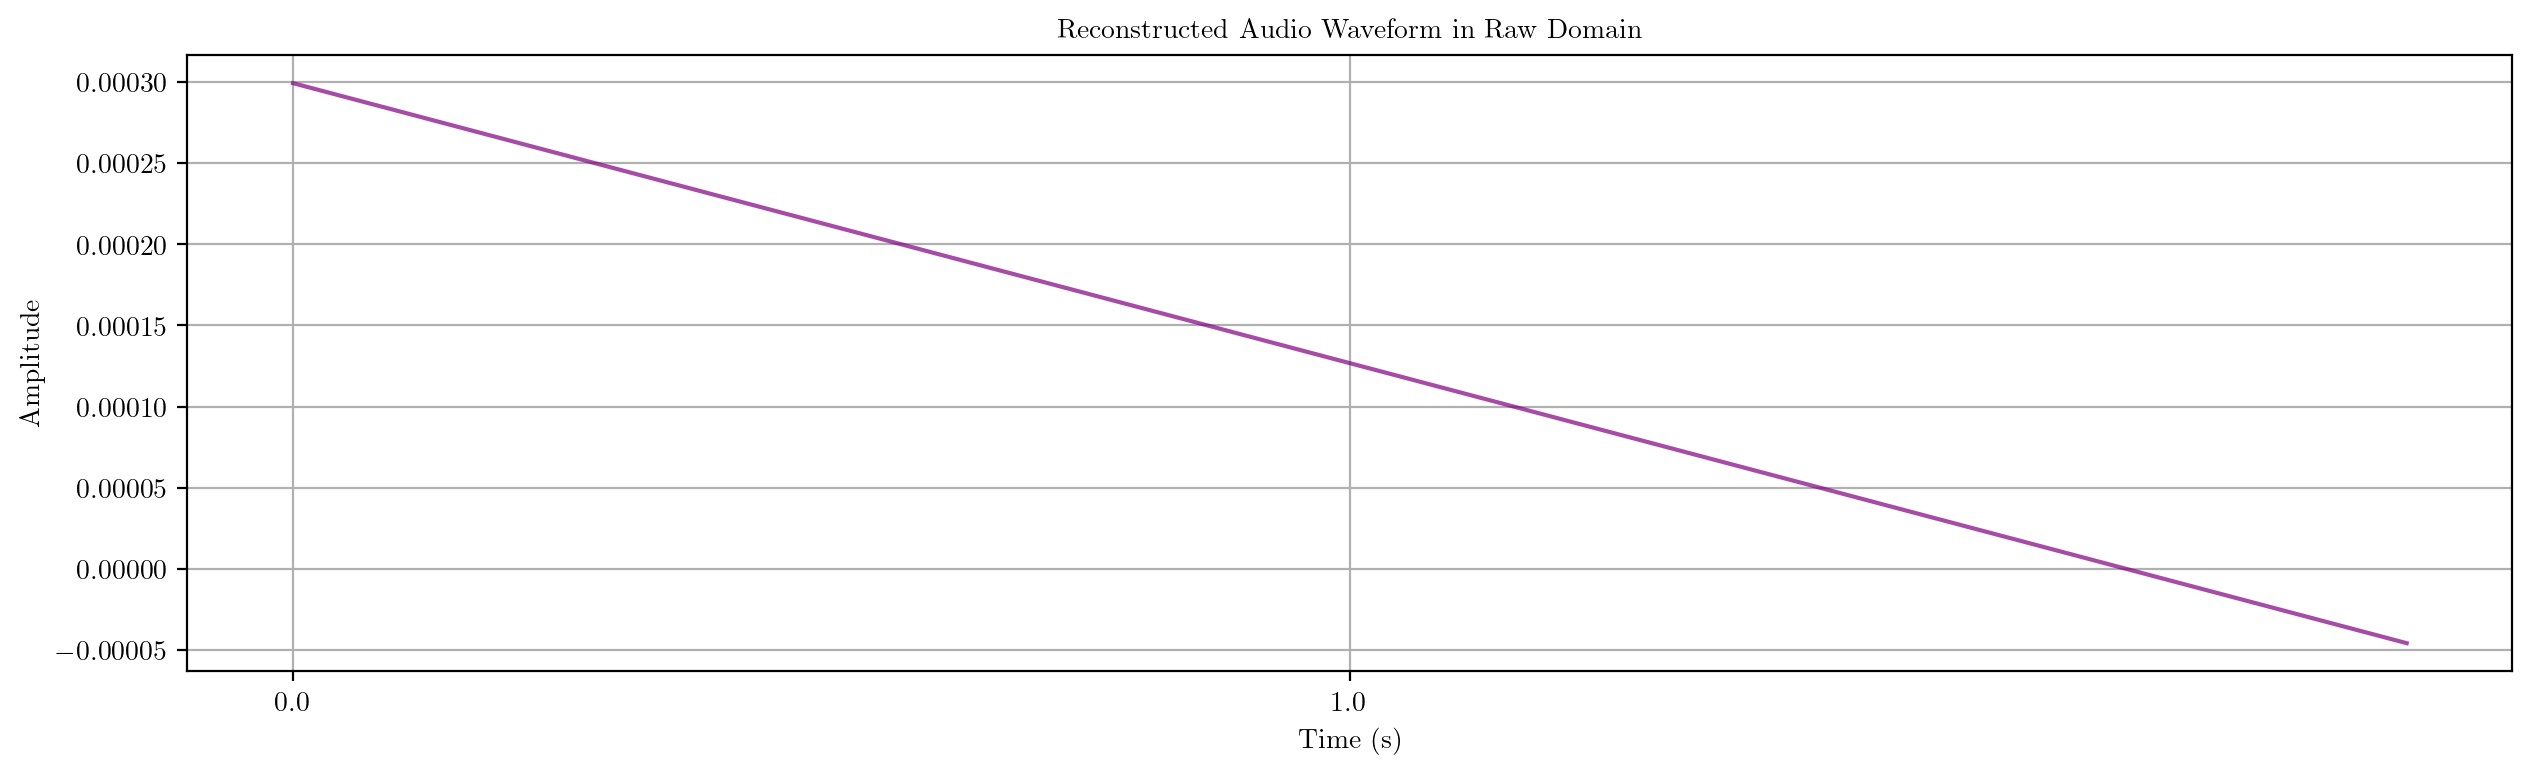

In [46]:
audio_plot(pred_audio1, sr, 'purple', 'Reconstructed Audio Waveform in Raw Domain')

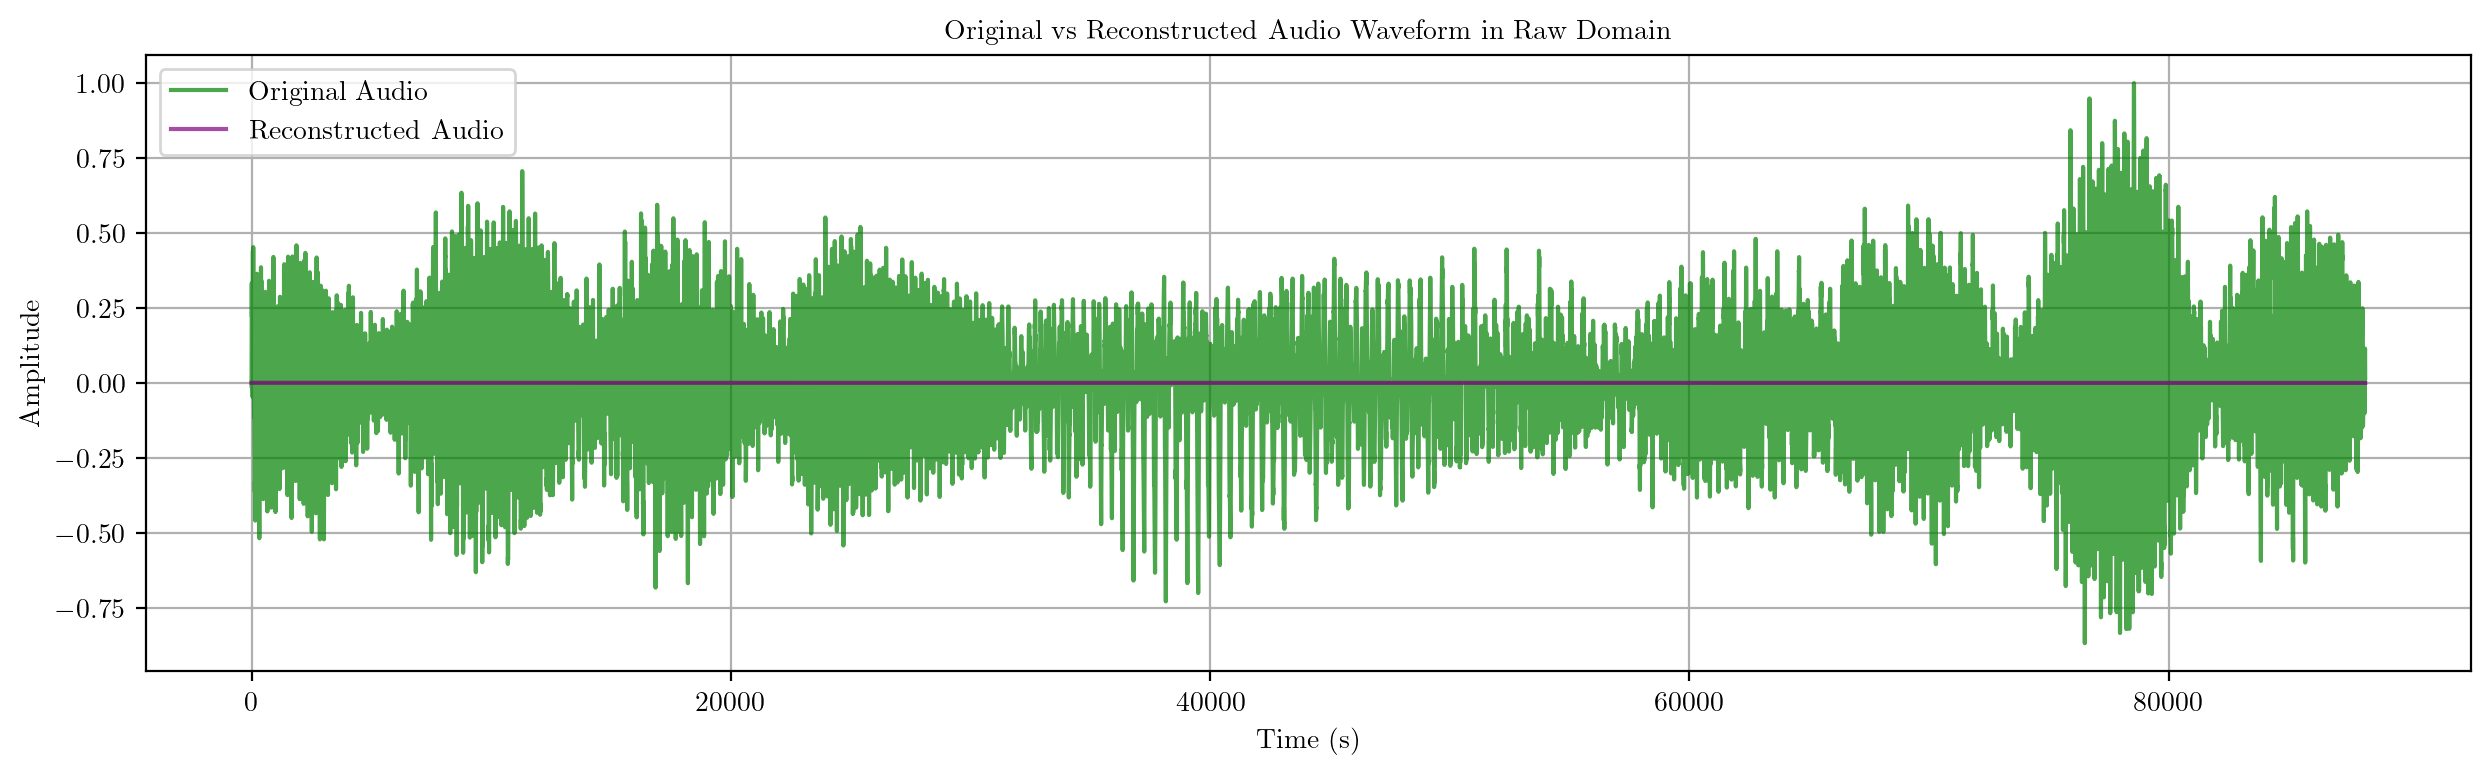

In [48]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'green', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio1, color = 'purple', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform in Raw Domain')
plt.grid()
plt.legend()
plt.show()